In [11]:
import pandas as pd
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
import numpy as np
import re

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# --- Preprocesamiento ---
def limpiar_tokens(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#|\d+", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stopwords.words('spanish') and len(word) > 2]

In [13]:
# Cargar datos
df = pd.read_csv('../data/data_train.csv')
text_column = "tweet_text" if "tweet_text" in df.columns else df.columns[0]
df['tokens'] = df[text_column].apply(limpiar_tokens)

In [14]:
# Etiqueta binaria
df['label'] = df['class'].apply(lambda x: 1 if x == 'anorexia' else 0)

In [15]:
# --- Entrenar modelo Word2Vec ---
modelo_w2v = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)

In [16]:
# --- Obtener vectores promedio ---
def vector_promedio(tokens, modelo):
    vectores = [modelo.wv[token] for token in tokens if token in modelo.wv]
    return np.mean(vectores, axis=0) if vectores else np.zeros(modelo.vector_size)

X = np.vstack(df['tokens'].apply(lambda tokens: vector_promedio(tokens, modelo_w2v)))
y = df['label']


In [17]:
#!pip install xgboost

In [18]:
# --- Entrenamiento XGBoost ---
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.2]
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


c:\Users\danir\Documents\TecDeMonterrey\Universidad\OctavoSemestre\EtapaEvaluacionFinal\etapaEvaluacionFinal\.env\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:31:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.2], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [19]:
# --- Evaluación ---
from sklearn.metrics import classification_report, roc_auc_score

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Mejor AUC en validación cruzada:", grid_search.best_score_)
print("AUC en test:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred, target_names=["Control", "Anorexia"]))

Mejor AUC en validación cruzada: 0.8508694741252881
AUC en test: 0.8670324278513761
              precision    recall  f1-score   support

     Control       0.78      0.72      0.75       141
    Anorexia       0.76      0.82      0.79       159

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.77       300
weighted avg       0.77      0.77      0.77       300



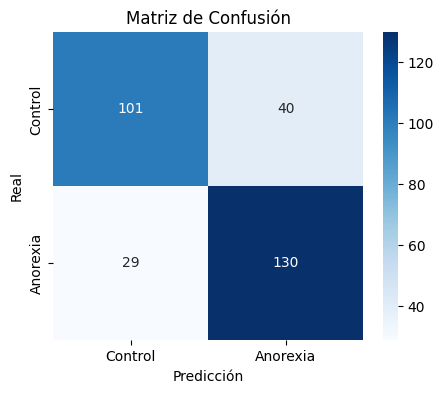

In [20]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Control", "Anorexia"], yticklabels=["Control", "Anorexia"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

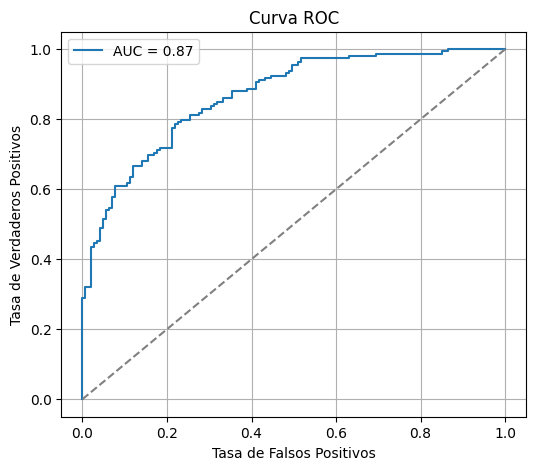

In [21]:
# --- Curva ROC ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()